In [33]:
import os
import glob
from skimage import transform
from skimage import color
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Filter out corrupted images

In [2]:
data_dir = "../input/train"

num_skipped =0
images_folder_names = os.listdir(data_dir)
for images_folder_name in images_folder_names:
    images_folder_path = os.path.join(data_dir, images_folder_name)
    images = glob.glob(os.path.join(images_folder_path, "*.png"))
    
    for image in images:
        try:
            fobj = open(image, "rb")
            is_png = tf.compat.as_bytes("PNG") in fobj.peek(10)
            
        finally:
            fobj.close()
        
        if not is_png:
            num_skipped += 1
            print(f"{num_skipped} corrupted images found.")
            # Delete corrupted image
            os.remove(image)

print(f"Deleted {num_skipped} images") 

Deleted 0 images


## Generate dataset

In [34]:
data_dir = "../input/train"
image_size = (32,32)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size= image_size,
    validation_split=0.25,
    subset="training",
#     color_mode = "grayscale",
    seed =1337
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=image_size,
    validation_split=0.25,
    subset="validation",
#     color_mode="grayscale",
    seed=1337
)

Found 39209 files belonging to 43 classes.
Using 29407 files for training.
Found 39209 files belonging to 43 classes.
Using 9802 files for validation.


## manually iterate over the dataset and retrieve batches of images

In [35]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

# train_ds 29407 files and each batch_size=32. So, size of train_ds is 919 and each one has 32 images
print(len(train_ds))

(32, 32, 32, 3)
(32,)
919


### class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [36]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


## Visualize the data

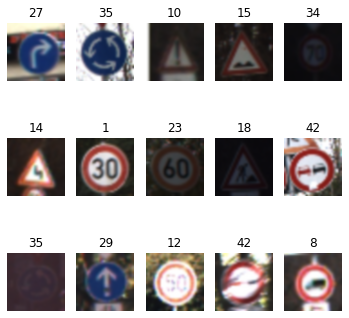

In [37]:
# here in train_ds 29407 files and each batch_size=32, So total no. of batch-- 29407//32 == 919
# train_ds.take(1) gives images, labels of 1st batch

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
for images, labels in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i+1)
        plt.imshow(np.squeeze(images[i].numpy().astype("uint8")), interpolation="bicubic")
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

In [38]:
data_augmentation = keras.Sequential(
    [
        
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

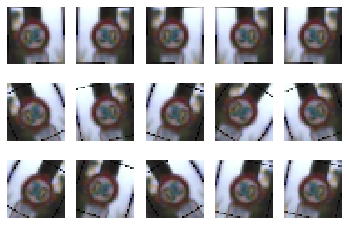

In [40]:
import matplotlib.pyplot as plt
for images, labels in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 5, i+1)
        plt.imshow((augmented_images[0].numpy().astype("uint8")))
        plt.axis("off")

In [41]:
## Here target label is int denoting the idx associated with the trafficSignal
## Since tf.keras.preprocessing.image_dataset_from_directory(
#     label_mode: 
#          'int': means that the labels are encoded as integers (e.g. for sparse_categorical_crossentropy loss).
#           'categorical' means that the labels are encoded as a categorical vector (e.g. for categorical_crossentropy loss).
#           'binary' means that the labels (there can be only 2) are encoded as float32 scalars with values 0 or 1 (e.g. for binary_crossentropy).
#           None (no labels).
# )

for image, label in train_ds.take(1):
    print(image.shape, type(image))
    print(label.shape, type(label))
    print(label)
    break

(32, 32, 32, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
(32,) <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[23 41 10 34 19  2  9  9 10 38  8  1  3 42 23 23 15 18 40 12 40 38 24 34
 41 31 32 12 12  3 18 41], shape=(32,), dtype=int32)


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [44]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [11]:

def make_model(input_shape, num_classes):
    
#     Input() is used to instantiate a Keras tensor.
    inputs = keras.Input(shape=input_shape)
    
    x = data_augmentation(inputs)
    x = layers.experimental.preprocessing.Rescaling(1/255.0)(x)
    x = layers.Conv2D(32, 3, strides=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, strides=3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    previous_block_activation = x
    
    for size in [128, 256, 516, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
        
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(units, activation=activation)(x)
    
    return keras.Model(inputs, outputs)

model = make_model(image_size + (3,), num_classes=43)

keras.utils.plot_model(model, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [24]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 32, 32, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 32, 32, 3)    0           sequential[3][0]                 
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 11, 11, 32)   896         rescaling_3[0][0]                
_______________________________________________________________________________________

In [30]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
919/919 [==============================] - 24s 26ms/step - loss: 0.6251 - accuracy: 0.7976 - val_loss: 0.5502 - val_accuracy: 0.8141
Epoch 2/50
919/919 [==============================] - 24s 26ms/step - loss: 0.5545 - accuracy: 0.8179 - val_loss: 0.5488 - val_accuracy: 0.8177
Epoch 3/50
919/919 [==============================] - 25s 27ms/step - loss: 0.5060 - accuracy: 0.8333 - val_loss: 0.4757 - val_accuracy: 0.8426
Epoch 4/50
919/919 [==============================] - 24s 26ms/step - loss: 0.4704 - accuracy: 0.8463 - val_loss: 0.4248 - val_accuracy: 0.8672
Epoch 5/50
919/919 [==============================] - 25s 27ms/step - loss: 0.4439 - accuracy: 0.8538 - val_loss: 0.4602 - val_accuracy: 0.8531
Epoch 6/50
919/919 [==============================] - 26s 28ms/step - loss: 0.4177 - accuracy: 0.8612 - val_loss: 0.3738 - val_accuracy: 0.8778
Epoch 7/50
919/919 [==============================] - 26s 28ms/step - loss: 0.3910 - accuracy: 0.8716 - val_loss: 0.3265 - val_accuracy: